In [6]:
'''
Library declare
@Author: MinHyung Lee
@Since: 2022/05/22
Used library:
pandas
numpy
featuretools
matplot
sklearn
seaborn

'''

import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import  r_regression, SelectKBest

from woodwork.logical_types import Categorical, Boolean
from sklearn.preprocessing import OrdinalEncoder
from math import  ceil
'''
Add plt config
@Author: MinHyung Lee
@Since: 2022/05/24

'''

import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.dpi'] = 600

pd.set_option('display.max_rows', 20)

random_state = 7777

unusable_col = ['App Name', 'App Id', 'Minimum Installs', 'Price', 'Currency', 'Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Last Updated', 'Editors Choice', 'Scraped Time', 'Free', 'Rating Count', 'Rating']

In [37]:


df = pd.read_csv('../Dataset/sampled_dataset.csv', index_col=[0])

# Drop unused columns
df = df.drop(unusable_col, axis=1)

# Encode string values
encoding = OrdinalEncoder()
encoding.fit(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']])
df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']] = encoding.transform(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']])

# Encode Size feature
A = df[df['Size'] == 'Varies with device'].index
df = df.drop(A,axis='index')
df = df.dropna()  # Drop Nan
# Calculate App size
# 1. "," drop
# 2. "M", "k" drop
df['Size'] =  np.where(df['Size'].str.contains('M'), df['Size'].str.replace(',','').str[:-1].astype('float64') , df['Size'].str.replace(',','').str[:-1].astype('float64')/1000)

#Encode Released column as a data type
df['Released'] = pd.to_datetime(df['Released'])
df['Released'].dt.strftime('%b %d, %Y')
df['Released'] = df['Released'].dt.strftime('%Y-%m-%d')
df.fillna(df.mean(), inplace=True)

test_df = df["Installs"]
test_df.to_csv("targetForKNN.csv")
df.drop(['Installs'], axis= 1, inplace=True)


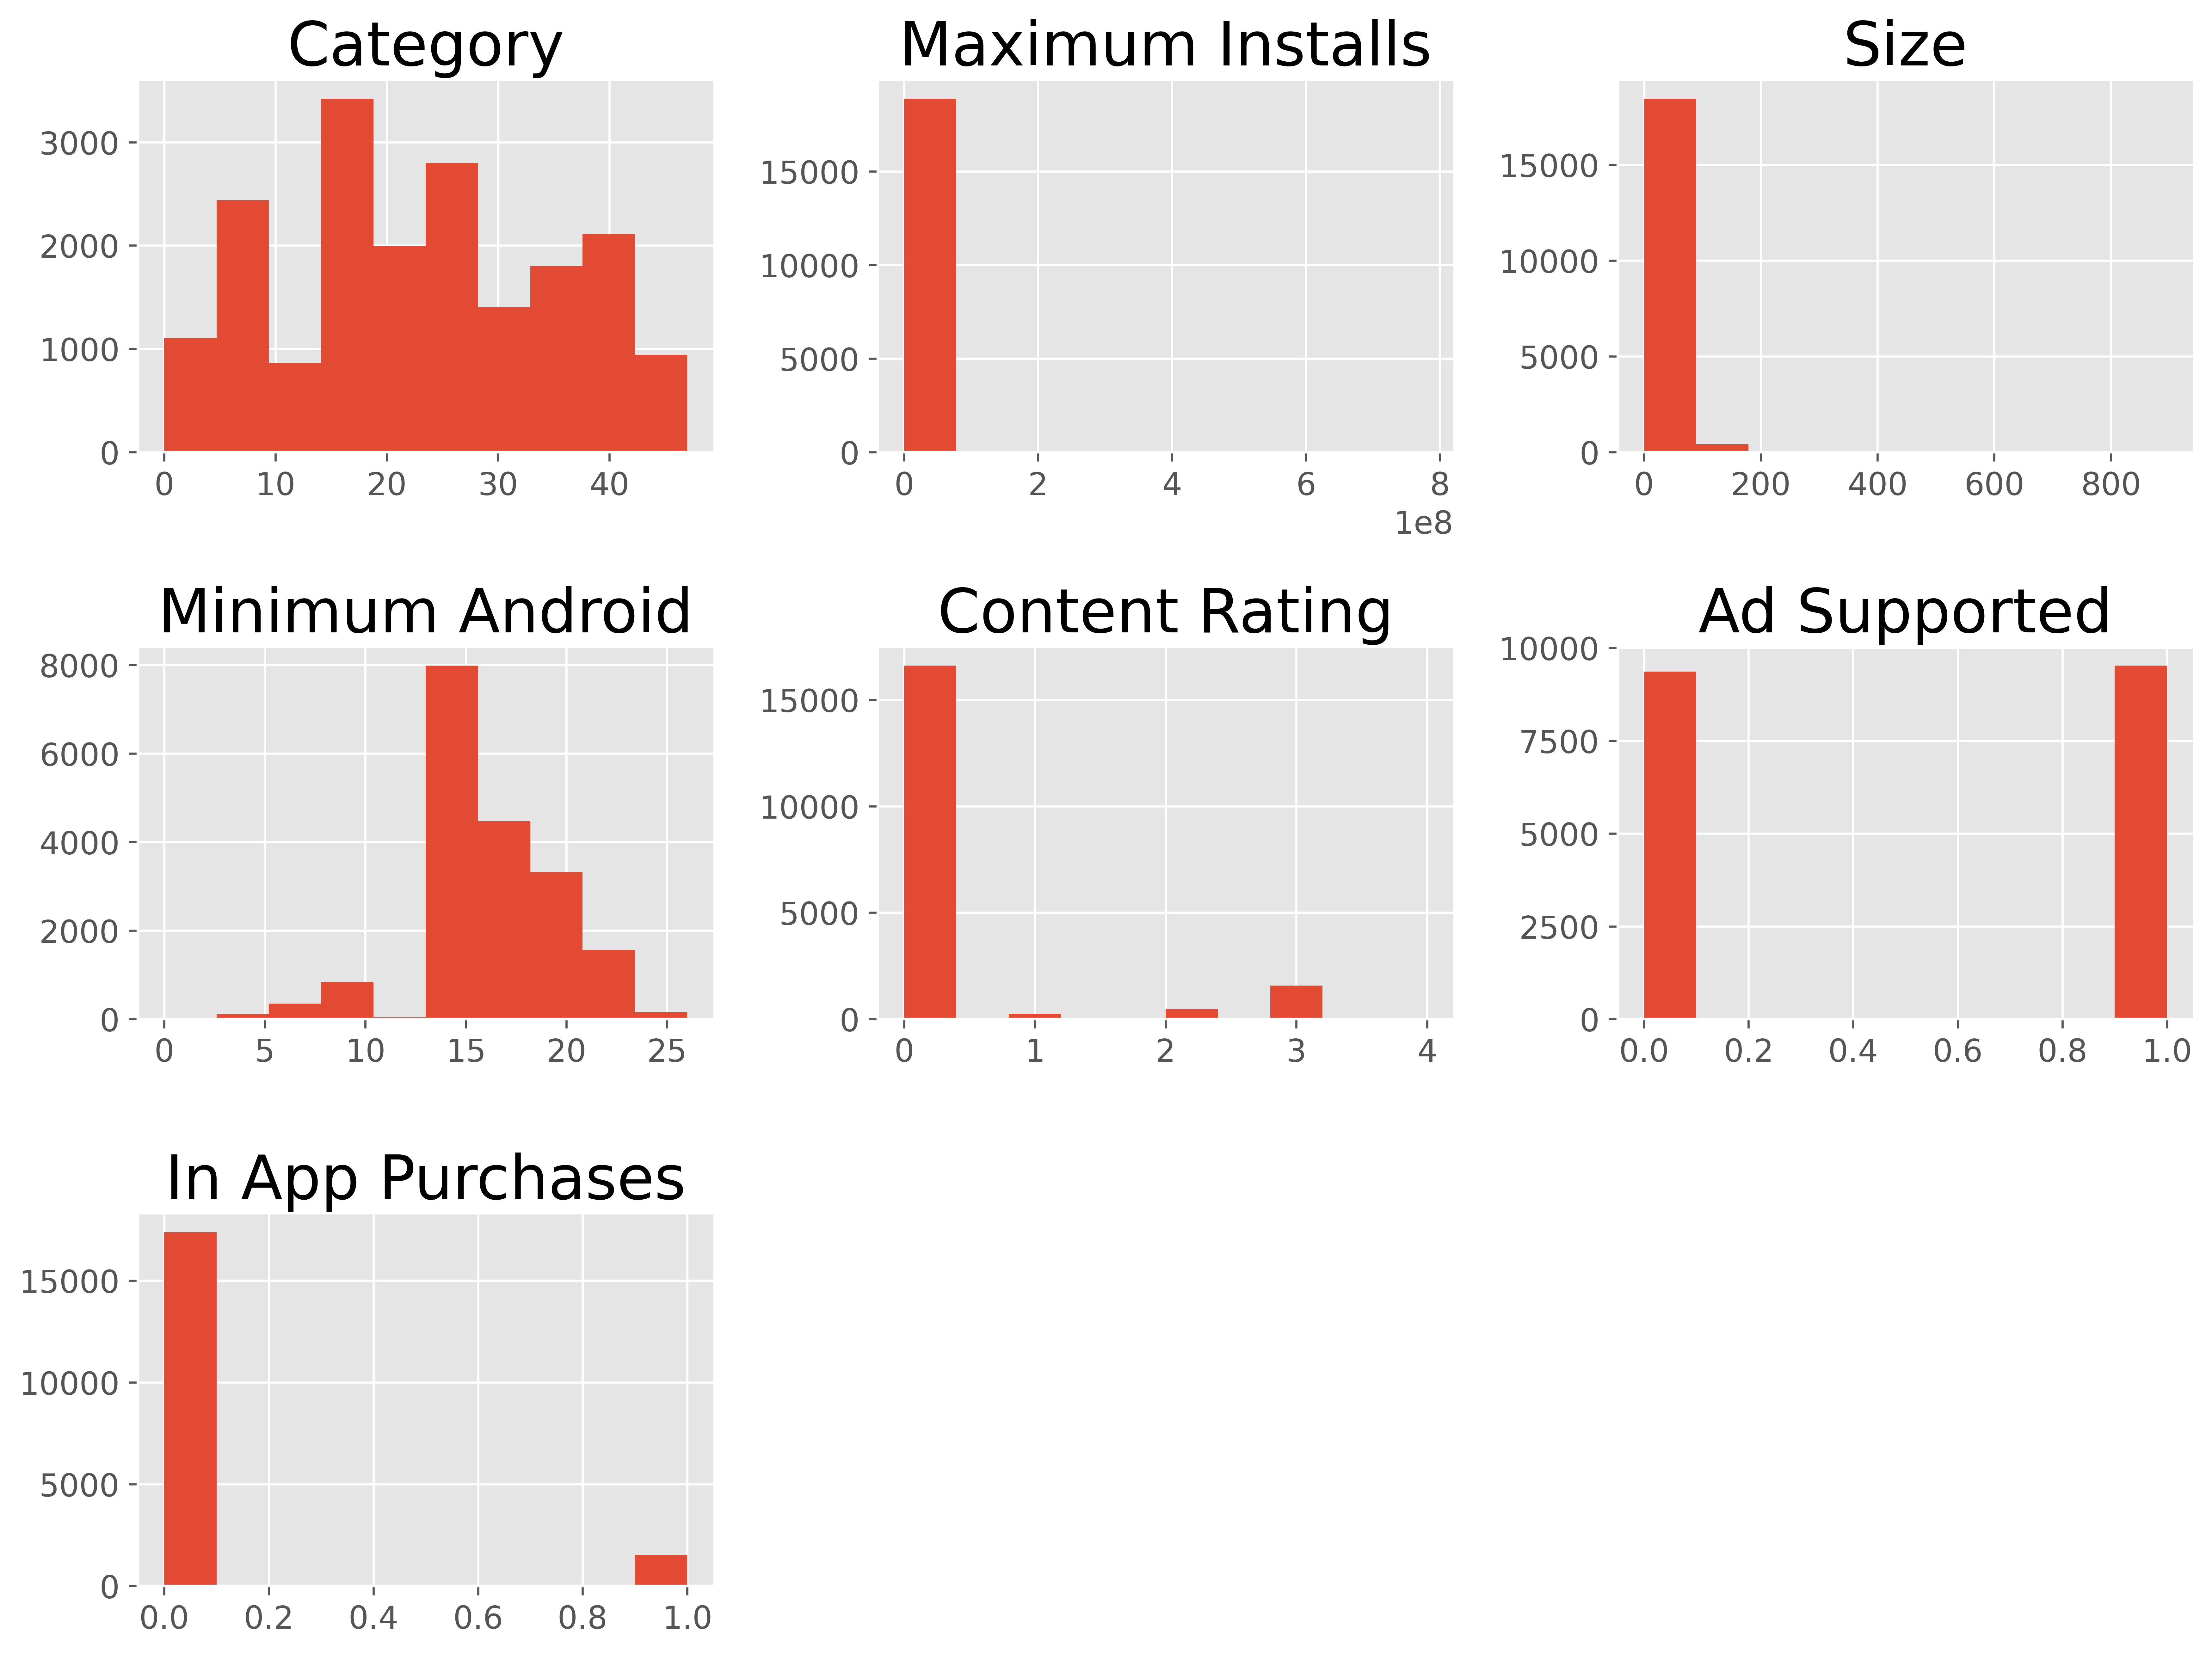

In [38]:
'''

@Author: MinHyung Lee
@Since: 2022/05/31

Visualize final features
'''

def make_subplot_layout(df, col_num):

    '''
    make_subplot_layout
    @Author: MinHyung Lee
    @Since: 2022/05/31
    Visualize each feature using subplots

    '''

    k = len(df.columns)
    row_num = ceil(k/col_num)
    for i in range(k) :
        plt.subplot(row_num,col_num,i+1)
        plt.hist(df.iloc[:,i])
        plt.title(df.columns[i])
    plt.tight_layout()
    plt.show()

make_subplot_layout(df.drop('Released', axis=1, inplace=False), 3)

## Feature Creation with feature tools

In [39]:
es = ft.EntitySet(id='Store')

In [40]:
df

,Category,Maximum Installs,Size,Minimum Android,Released,Content Rating,Ad Supported,In App Purchases
2249330,43.0,170,32.0,9.0,2015-02-27,0.0,0.0,0.0
1142461,15.0,6253,2.8,16.0,2015-10-01,0.0,0.0,0.0
361807,18.0,22,3.7,15.0,2020-09-13,3.0,1.0,0.0
343573,42.0,41,11.0,21.0,2020-11-01,0.0,0.0,0.0
1968284,14.0,5094,67.0,18.0,2021-04-14,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...
1781325,24.0,2042,3.1,16.0,2018-11-24,0.0,1.0,0.0
158776,17.0,33017,8.4,15.0,2020-04-30,0.0,1.0,0.0
195232,11.0,113,55.0,14.0,2016-12-07,0.0,1.0,0.0
265205,40.0,61965,3.4,20.0,2014-01-11,0.0,1.0,0.0


In [41]:
# Set Entityset by dataframe data
es.add_dataframe(dataframe_name="store_log",
                 dataframe=df,
                 index="index",
                 logical_types= {
                     "Ad Supported": Boolean,
                     "In App Purchases": Boolean,
                     "Category": Categorical,
                     "Minimum Android": Categorical
                 })

Entityset: Store
  DataFrames:
    store_log [Rows: 18889, Columns: 9]
  Relationships:
    No relationships

In [42]:
#Check dataset schema briefly
es["store_log"].ww.schema


,Logical Type,Semantic Tag(s)
Column,,
index,Integer,['index']
Category,Categorical,['category']
Maximum Installs,Integer,['numeric']
Size,Double,['numeric']
Minimum Android,Categorical,['category']
Released,Datetime,[]
Content Rating,Double,['numeric']
Ad Supported,Boolean,[]
In App Purchases,Boolean,[]


In [43]:
'''

@Author: MinHyung Lee
@Since: 2022/05/23

Use dfs for create year, month, day features
'''


features, feature_names = ft.dfs(entityset=es,
                                 target_dataframe_name='store_log',
                                 trans_primitives=['year', 'month', 'day'])

df = features


## SelectKBest

In [49]:
X = df.drop(["Maximum Installs"], axis = 1)
y = df[['Maximum Installs']]
y = y.to_numpy()
# Select best feature using selectKBest and scoring option is r_regression
select = SelectKBest(score_func= r_regression, k = 5)
fit = select.fit(X, y)

df_columns = pd.DataFrame(X.columns)
df_scores = pd.DataFrame(fit.scores_)

featureScores = pd.concat([df_columns, df_scores], axis = 1)
featureScores.columns = ["Factors", 'Score']
# Show 10 largest features

print(featureScores.nlargest(10,'Score'))

fit = select.fit_transform(X, y)

            Factors     Score
5  In App Purchases  0.064555
1              Size  0.041801
3    Content Rating  0.023387
0          Category  0.021826
6     DAY(Released)  0.005934
4      Ad Supported  0.004757
2   Minimum Android  0.001781
7   MONTH(Released) -0.004599
8    YEAR(Released) -0.025482


In [47]:
fit

array([[43.0, 32.0, 9.0, ..., 27, 2, 2015],
       [15.0, 2.8, 16.0, ..., 1, 10, 2015],
       [18.0, 3.7, 15.0, ..., 13, 9, 2020],
       ...,
       [11.0, 55.0, 14.0, ..., 7, 12, 2016],
       [40.0, 3.4, 20.0, ..., 11, 1, 2014],
       [39.0, 4.2, 13.0, ..., 3, 3, 2020]], dtype=object)

## PCA

In [9]:
X = StandardScaler().fit_transform(X)

# Set variance ratio to 0.9
pca = PCA(.90)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents)
principalDf.head()

,0,1,2,3,4,5,6,7
0,-1.607969,-0.376904,0.571787,0.217856,-2.063748,-1.514923,1.320954,1.365889
1,-1.250352,-0.878017,1.250777,-0.327520,1.840168,-0.036014,0.439968,-0.550869
2,-0.037298,1.638919,-1.376501,-1.439796,0.590566,2.104716,0.972264,-0.273672
3,1.018626,-1.251197,1.065957,-2.274559,0.773440,-0.203238,-0.738781,-0.653542
4,2.625881,3.701159,-0.150814,0.794929,0.403729,-0.482309,0.710364,-0.596542


In [10]:
principalDf.to_csv("preprocessed_feature.csv")
y.to_csv("preprocessed_target.csv")